# Adaptancuón de dominio entre dígitos

#### Este ejemplo es una modificación del creado por *Rémi Flamary, Nicolas Courty*

Ideas basadas en el trabajo:

N. Courty, R. Flamary, D. Tuia, A. Rakotomamonjy, "[Optimal transport for domain adaptation](http://remi.flamary.com/biblio/courty2016optimal.pdf)", Pattern Analysis and Machine Intelligence, IEEE Transactions on , 2016.

![otda.png](http://remi.flamary.com/cours/otml/otda.png)


In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.manifold import TSNE
import ot

### Carga de datos
Cada imagen es de tamaño 28x28


In [2]:
datos = np.load('data/mnist_usps.npz')

xs,ys = datos['xs'],datos['ys']
xt,yt = datos['xt'],datos['yt']

# Normalización: Los valores de pixeles varian entre 0 y 255
#                queremos que varien entre 0 y 1.
xs = xs / xs.sum(1,keepdims=True)
xt = xt / xt.sum(1,keepdims=True)

ns = xs.shape[0]
nt = xt.shape[0]

### Visualizaciónes





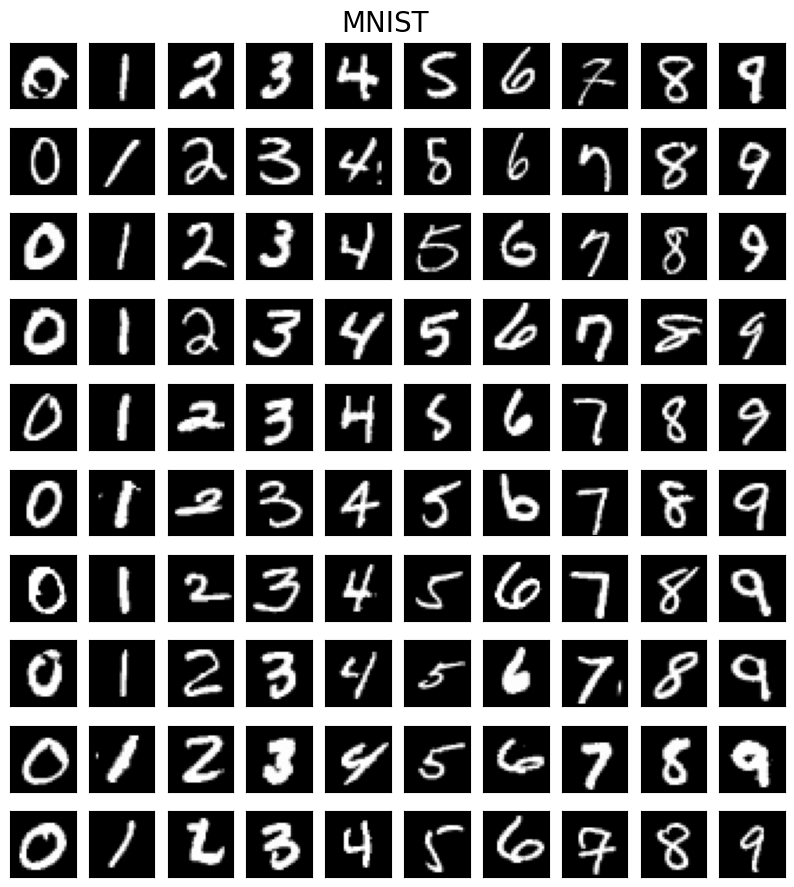

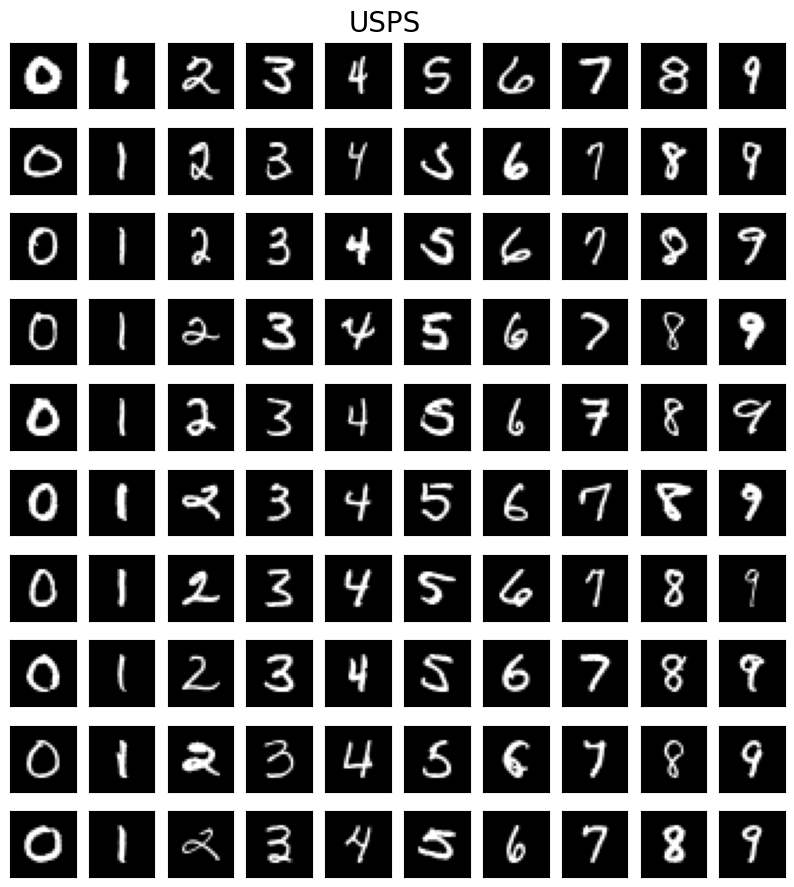

In [3]:
def plot_imagen(x):
    pl.imshow(x.reshape((28,28)), cmap='gray')
    pl.xticks(())
    pl.yticks(())

cantidad_imagenes = 10

# MNIST (Será el Source)
pl.figure(1, (cantidad_imagenes, cantidad_imagenes))
for i in range(cantidad_imagenes*cantidad_imagenes):
    pl.subplot(cantidad_imagenes, cantidad_imagenes, 1+i)
    c = i%cantidad_imagenes
    plot_imagen(xs[np.where(ys==c)[0][i//cantidad_imagenes], :])
pl.gcf().suptitle("MNIST", fontsize=20);
pl.gcf().subplots_adjust(top=0.95)
    
# USPS (Será el Target)
pl.figure(2,(cantidad_imagenes, cantidad_imagenes))
for i in range(cantidad_imagenes*cantidad_imagenes):
    pl.subplot(cantidad_imagenes, cantidad_imagenes, 1+i)
    c = i%cantidad_imagenes
    plot_imagen(xt[np.where(yt==c)[0][i//cantidad_imagenes], :])
pl.gcf().suptitle("USPS", fontsize=20);
pl.gcf().subplots_adjust(top=0.95)

Hay diferencias considerables en los dígitos 1, 2 y 5.

In [4]:
# Entrenamos SVM en MNIST
clasificador = SVC(C=1, gamma=1e2)
clasificador.fit(xs, ys)

# Calculamos el accuracy
accuracy_MNIST = clasificador.score(xs, ys)
accuracy_USPS = clasificador.score(xt, yt)

print('Accuracy MNIST={:1.3f} (Source)'.format(accuracy_MNIST))
print('Accuracy USPS={:1.3f} (Target)'.format(accuracy_USPS))

Accuracy MNIST=0.978 (Source)
Accuracy USPS=0.687 (Target)


Observamos que el clasificador tiene una muy buena performance en el set de Source $X_s$ pero es muy inferior en el set de Target $X_T$. A continuación utilizamos TSNE para visualziar las distribuciones en $\mathbb{R}^2$.

In [5]:
# Juntamos los datos de ambas distrivuciones
xsxt = np.concatenate((xs,xt), axis=0) 

proyeccion = TSNE().fit_transform(xsxt) 

xs_proyectado = proyeccion[:ns,:] 
xt_proyectado = proyeccion[ns:,:]

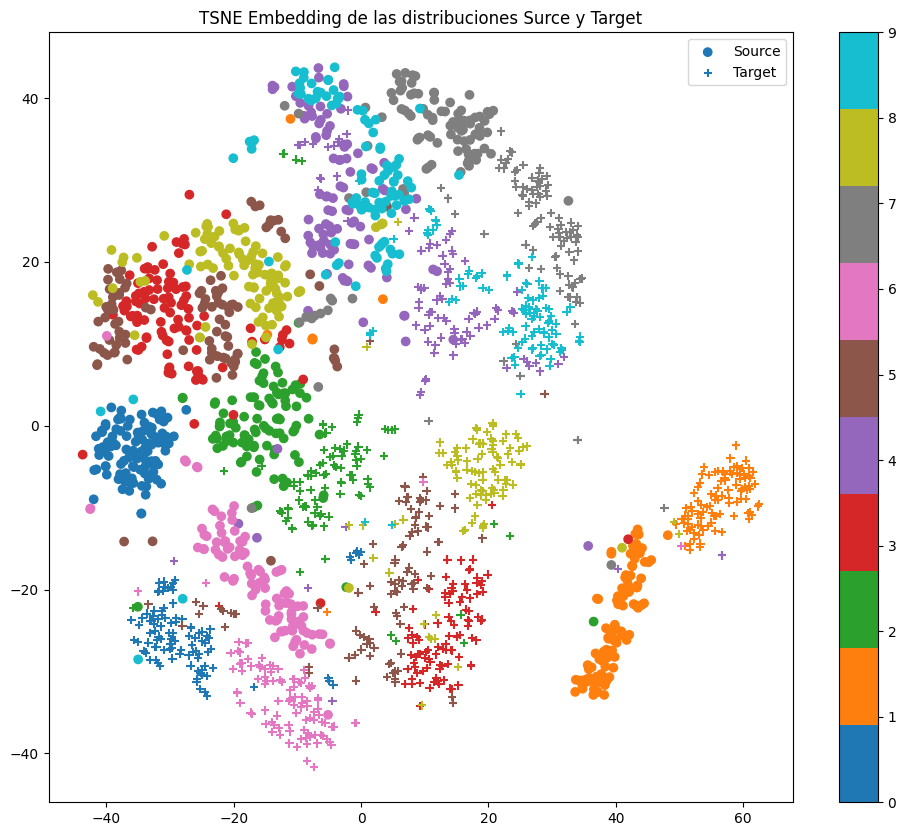

In [7]:
pl.figure(3, (12,10))

pl.scatter(xs_proyectado[:,0], xs_proyectado[:,1], c=ys, marker='o', cmap='tab10', label='Source')
pl.scatter(xt_proyectado[:,0], xt_proyectado[:,1], c=yt, marker='+', cmap='tab10', label='Target')
pl.legend()
pl.colorbar()
pl.title('TSNE Embedding de las distribuciones Surce y Target');

Se puede observar que cada distribución tiene sus clases relativamente bien agrupadas, pero también observamos que cada grupo queda separado entre las distribuciones. La técnica de Adaptación de Dominio con Transporte Óptimo se bases en

1. Calcular el transporte óptimo entre los datos 
1. Aplicar el mapeo baricéntrico
1. Estimar un nuevo clasificador en los datos mapeados

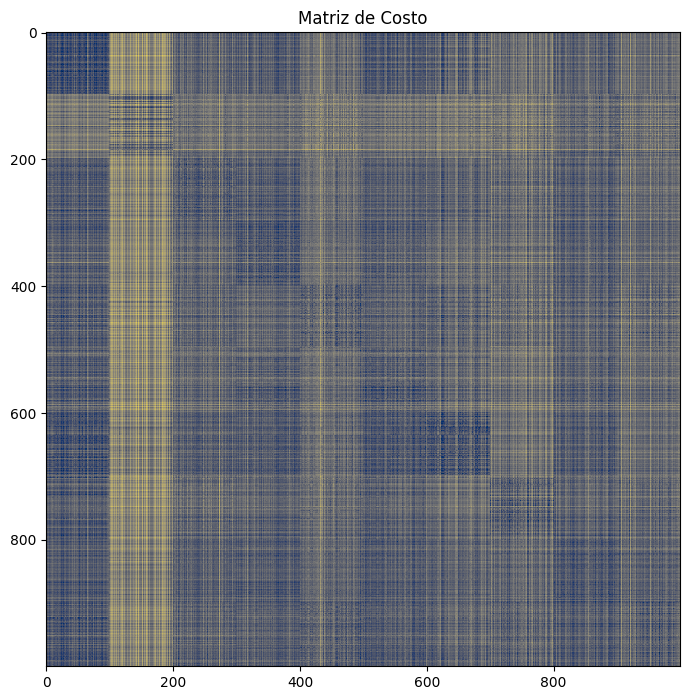

In [4]:
# Matriz de costo
cost_matrix = ot.dist(xs, xt, metric='euclidean')

plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.title('Matriz de Costo')
plt.imshow(cost_matrix, cmap = "cividis", interpolation='nearest')

##### Lo primero que llama la atención es que los dígitos asociados a la clase $1$ de USPS es sumamente diferente al resto de clases, tanto del set USPS como del set MNIST.

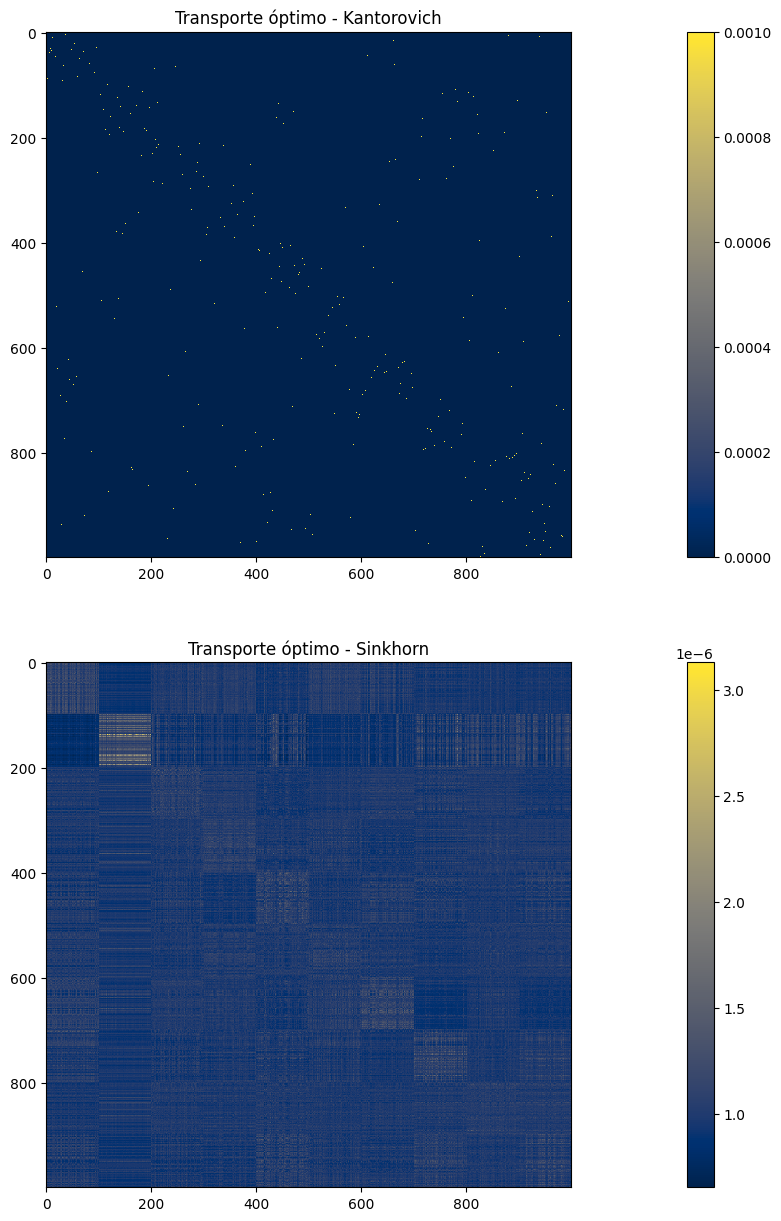

In [6]:
# Distribución uniforme en los datos. A cada dígito le damos un peso
# de 1/1000 (dado que son 1000 imagenes en cada conjunto)
source_distribution = np.ones((xs.shape[0],)) / xs.shape[0]
target_distribution = np.ones((xt.shape[0],)) / xt.shape[0]

# Calculamos el transporte óptimo de Kantorovich y la versión regularizada de Sinkhorn
ot_kantorovich = ot.emd(source_distribution, target_distribution, cost_matrix)
ot_sinkhorn = ot.sinkhorn(source_distribution, target_distribution, cost_matrix, reg = 1e-1)


plt.figure(figsize=(30, 15))
plt.subplot(2, 1, 1)
plt.imshow(ot_kantorovich, cmap = "cividis", interpolation='nearest')
plt.title("Transporte óptimo - Kantorovich")
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(ot_sinkhorn, cmap = "cividis", interpolation='nearest')
plt.title("Transporte óptimo - Sinkhorn")
plt.colorbar()

En ambos casos observamos que la mayoria de los transportes no nulso se dan en la anti diagonal, lo cual quiere decir que en promedio cada clase se mapea en su correspondiente clase. Para lo que sigue trabajaremos solo con la versión de Kantorovich.

Mapeo baricéntrico.

In [13]:
# Aplicamos a xt el plan de transporte
xt_mapeado = ns * np.dot(ot_kantorovich, xt)

# Entrenamos un nuevo clasificador en xt_mapped con las etiquetas de ys
clasificador_kantorovich= SVC(C=1,gamma=1e1)
clasificador_kantorovich.fit(xt_mapeado, ys)

# Accuracy de este nuevo clasificador en el target
accuracy_USPS_kantorovich = clasificador_kantorovich.score(xt,yt)

print('Accuracy: MNIST={:1.3f}'.format(accuracy_MNIST))
print('Accuracy: USPS={:1.3f}'.format(accuracy_USPS))
print('Accuracy (EMD): USPS={:1.3f}'.format(accuracy_USPS_kantorovich))

Accuracy: MNIST=0.978
Accuracy: USPS=0.687
Accuracy (EMD): USPS=0.764


Al aplicar el plan de transporte óptimo de Kantorovich logramos mejoramos el Accuracy en $7.7 \%$.

---
##### Podemos ver como afecta la regularzación al accuracy
---

In [14]:
exponentes = np.array([3, 2, 1, 0, -1, -2, -3], dtype=float)

accuracies = []

for exp in exponentes:
    ot_sinhorn_matrix = ot.sinkhorn(source_distribution, target_distribution, cost_matrix, reg=10**exp)
    xt_mapped_sinkhorn = ns * np.dot(ot_sinhorn_matrix, xt)
    clasificador_aux = SVC(C=1, gamma=1e1)
    clasificador_aux.fit(xt_mapped_sinkhorn, ys)
    accuracies.append(clasificador_aux.score(xt, yt))

/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


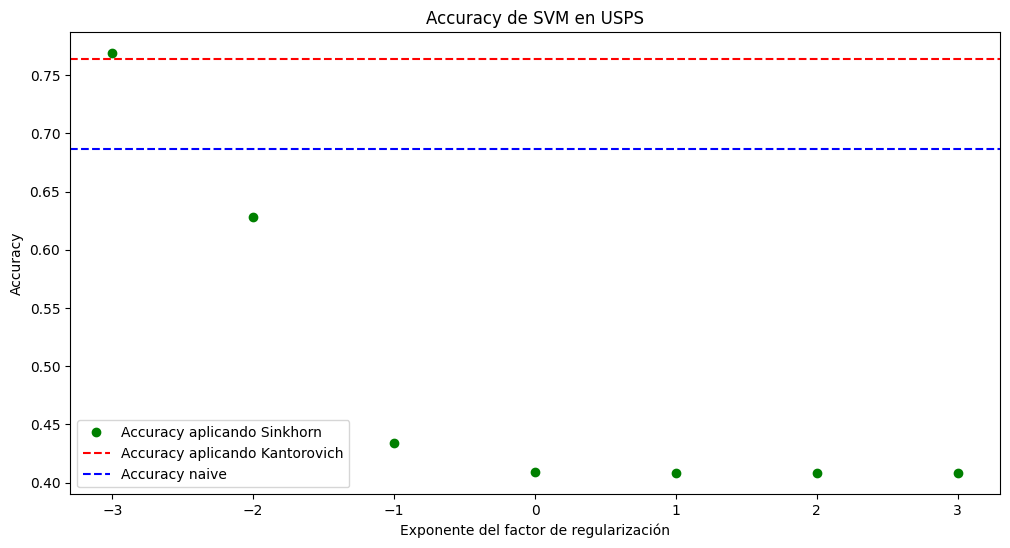

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(exponentes, accuracies, 'go', label="Accuracy aplicando Sinkhorn")
plt.axhline(accuracy_USPS_kantorovich, label="Accuracy aplicando Kantorovich", color = "red", linestyle="--")
plt.axhline(accuracy_USPS, label="Accuracy naive", color = "blue", linestyle="--")
plt.xlabel("Exponente del factor de regularización")
plt.ylabel("Accuracy")
plt.title("Accuracy de SVM en USPS")
plt.legend()

En lo anterior, 'Accuracy naive' hace referencia a no aplicar ninguna versión de transporte óptimo.

#### TNSE del mapeo

In [16]:
xt_mapped_xt = np.concatenate((xt_mapeado, xt), axis=0)

xp = TSNE().fit_transform(xt_mapped_xt)

xps=xp[:ns,:]
xpt=xp[ns:,:]

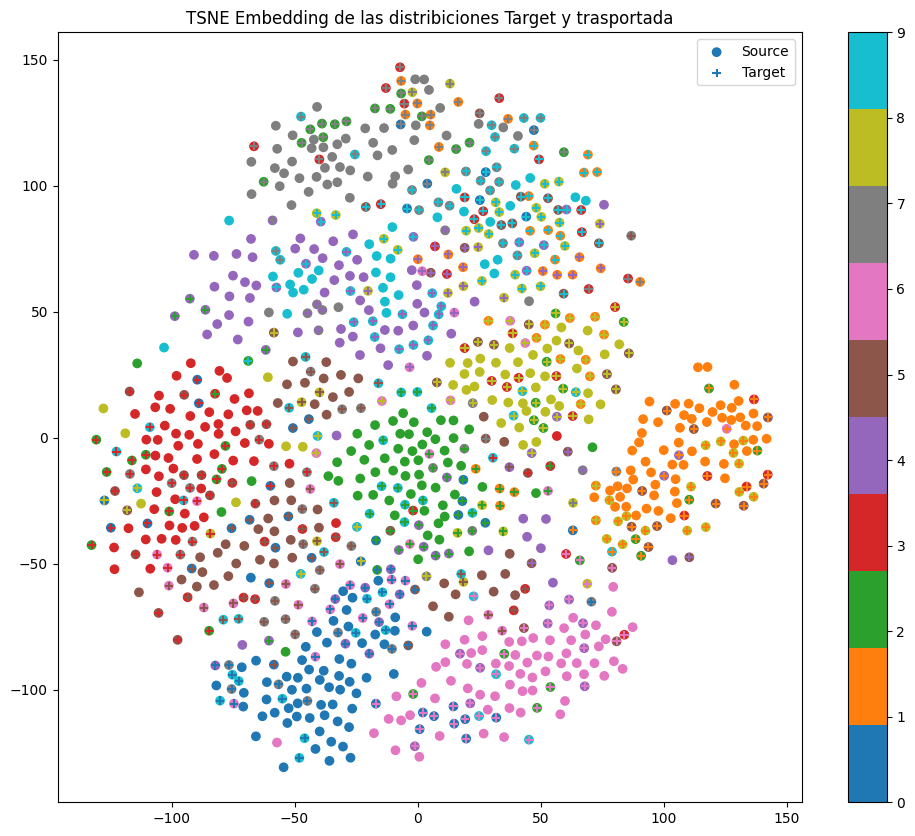

In [17]:
pl.figure(6,(12,10))

pl.scatter(xps[:,0],xps[:,1],c=ys,marker='o',cmap='tab10',label='Source')
pl.scatter(xpt[:,0],xpt[:,1],c=yt,marker='+',cmap='tab10',label='Target')
pl.legend()
pl.colorbar()
pl.title('TSNE Embedding de las distribiciones Target y trasportada');

#### Visualización de datos transportados

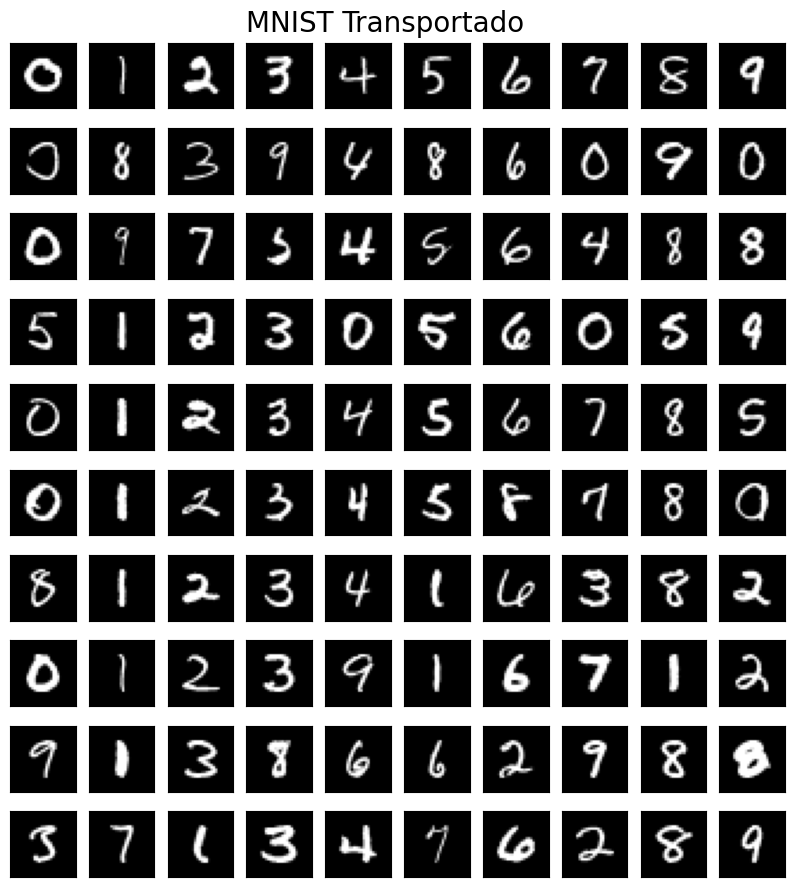

In [18]:
pl.figure(1, (cantidad_imagenes, cantidad_imagenes))
for i in range(cantidad_imagenes*cantidad_imagenes):
    pl.subplot(cantidad_imagenes, cantidad_imagenes, 1+i)
    c = i%cantidad_imagenes
    plot_imagen(xt_mapeado[np.where(ys==c)[0][i//cantidad_imagenes],:])
pl.gcf().suptitle("MNIST Transportado", fontsize=20);
pl.gcf().subplots_adjust(top=0.95)